# Pyramid pooling module

Paper: https://arxiv.org/pdf/1612.01105.pdf

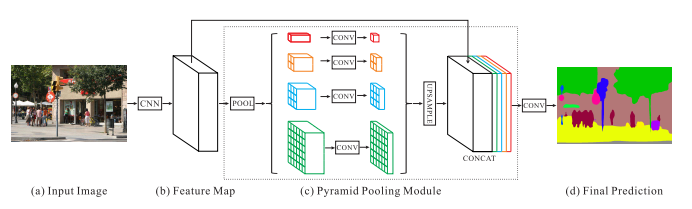

PPM是一种相对较好的充分利用全局信息的方式。这种保留全局信息的思路其实与ASPP(Atrous Spatial Pyramid Pooling) 很相似。从直觉上来看，这种多尺度的pooling确实是**可以在不同的尺度下来保留全局信息，比起普通的单一pooling更能保留全局上下文信息**。

论文中金字塔池化模块是4层，每层的size分别是1×1,2×2,3×3,6×6。

* 首先，对特征图分别池化到目标size，然后对池化后的结果进行1×1卷积将channel减少到原来的1/N,这里N就为4。
* 接着，对上一步的每一个特征图利用双线性插值上采样得到原特征图相同的size，然后将原特征图和上采样得到的特征图按channel维进行**concatenate**，得到的channel是原特征图的channel的两倍。
* 最后再用1×1卷积将channel缩小到原来的channel。最终的特征图和原来的特征图size和channel是一样的。

In [44]:
import torch
from torch import nn
import torch.nn.functional as F

class PPM(nn.Module):
    """Pyramid pooling module"""
    
    def __init__(self,inchannel,outchannel,**kwargs):
        super(PPM,self).__init__()
        # 将channel减少到原来的1/4
        inter_channels = int(inchannel / 4)
        self.conv1 = nn.Conv2d(inchannel,inter_channels,1,**kwargs)
        self.conv2 = nn.Conv2d(inchannel,inter_channels,1,**kwargs)
        self.conv3 = nn.Conv2d(inchannel,inter_channels,1,**kwargs)
        self.conv4 = nn.Conv2d(inchannel,inter_channels,1,**kwargs)
        self.out = nn.Conv2d(inchannel*2,outchannel,1)
    
    def pool(self,x,size):
        # 自适应的平均池化，目标size分别为1x1,2x2,3x3,6x6
        avge = nn.AdaptiveAvgPool2d(size)
        return avge(x)
 
    def upsample(self,x,size):
        # 上采样使用双线性插值
        return F.interpolate(x,size,mode ='bilinear', align_corners=True)
 
    def forward(self,x):
        size = x.size()[2:]#(x[2],x[3])
        interout1 = self.pool(x,1)#1x1
        interout2 = self.pool(x,2)#2x2
        interout3 = self.pool(x,3)#3x3
        interout6 = self.pool(x,6)#6x6
 
        # 将channel减少到原来的1/4
        out1 = self.conv1(interout1)
        out2 = self.conv2(interout2)
        out3 = self.conv3(interout3)
        out6 = self.conv4(interout6)
 
        # 双线性插值上采样
        out1_1 = self.upsample(out1,size[0])
        out2_1 = self.upsample(out2,size[0])
        out3_1 = self.upsample(out3,size[0])
        out6_1 = self.upsample(out6,size[0])
        
        # concat 四个池化的结果
        out5 = torch.cat([x,out1_1,out2_1,out3_1,out6_1],dim = 1)
        # 将channel缩小到原来的channel
        out = self.out(out5)
        return out

In [45]:
x = torch.rand((1,512,13,13))    
f = PPM(512,256)
print('PPM out shape =',f(x).shape)

PPM out shape = torch.Size([1, 256, 13, 13])
